### Classifying cats 🐈 vs dogs 🐕 pictures

Before starting to play with this notebook [download the necessary dataset](https://drive.google.com/file/d/1WaTomHWXNGmtaBz5U-jZyL01yHImujhj/view?usp=sharing) and uncompress it in the same directory as this notebook. The dataset contains three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 500 samples of each class.

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely connected classifier. The first part is called the convolutional base of the model.

#### Instantiating a small convnet

Because we’re attacking a binary-classification problem, we’ll end the network with a single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the network is looking at one class or the other.

In [1]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


Let’s look at how the dimensions of the feature maps change with every successive layer:

In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

#### Configuring the model for training

Because we ended the network with a single sigmoid unit, we’ll use binary crossentropy as the loss.

In [3]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#### Data preprocessing

Data should be formatted into appropriately preprocessed floating-point tensors before being fed into the network. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the network are roughly as follows:

* Read the picture files.
* Decode the JPEG content to RGB grids of pixels.
* Convert these into floating-point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

#### Using ImageDataGenerator to read images from directories

In [4]:
import os

base_dir = '/src/cats_and_dogs'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

Keras has a module with image-processing helper tools, located at keras.preprocessing.image to take care of these steps automatically:

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let’s look at the output of one of these generators:

In [6]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


####  Fitting the model using a batch generator

*fit_generator* method, the equivalent of fit for data generators, expects as its first argument a Python generator that will yield batches of inputs and targets indefinitely. After having drawn *steps_per_epoch* batches from the generator the fitting process will go to the next epoch. In this case, batches are 20 samples, so it will take 100 batches until we see our target of 2,000 samples:

In [7]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 73s 729ms/step - loss: 0.6820 - acc: 0.5540 - val_loss: 0.6489 - val_acc: 0.6300
Epoch 2/30
100/100 [==============================] - 71s 707ms/step - loss: 0.6354 - acc: 0.6420 - val_loss: 0.6417 - val_acc: 0.6360
Epoch 3/30
100/100 [==============================] - 75s 753ms/step - loss: 0.5879 - acc: 0.6870 - val_loss: 0.6207 - val_acc: 0.6240
Epoch 4/30
100/100 [==============================] - 70s 699ms/step - loss: 0.5577 - acc: 0.7170 - val_loss: 0.5831 - val_acc: 0.6910
Epoch 5/30
100/100 [==============================] - 71s 711ms/step - loss: 0.5252 - acc: 0.7355 - val_loss: 0.6117 - val_acc: 0.6740
Epoch 6/30
100/100 [==============================] - 72s 716ms/step - loss: 0.5020 - acc: 0.7555 - val_loss: 0.5663 - val_acc: 0.6950
Epoch 7/30
100/100 [==============================] - 67s 674ms/step - loss: 0.4761 - acc: 0.7680 - val_loss: 0.5463 - val_acc: 0.7150
Epoch 8/30
100/100 [==============================] - 6

It’s good practice to always save our model after training:

In [8]:
model.save('cats_and_dogs_small_1.h5')

#### Displaying curves of loss and accuracy during training

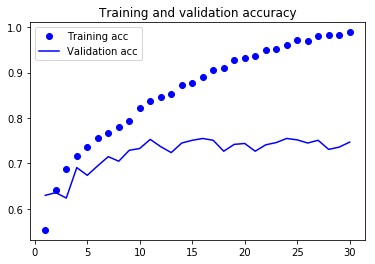

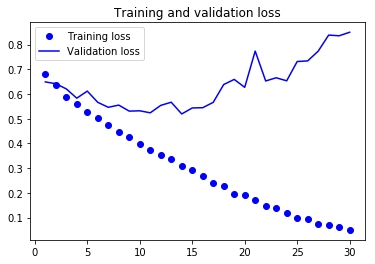

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy stalls at 70–72%. The validation loss reaches its minimum after only five epochs and then stalls, whereas the training loss keeps decreasing linearly until it reaches nearly 0.

Because we have relatively few training samples (2,000), overfitting is our number-one concern.

#### Using data augmentation

Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

#### Setting up a data augmentation configuration via ImageDataGenerator

In [11]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available:

* **rotation_range** is a value in degrees (0–180), a range within which to randomly rotate pictures.
* **width_shift** and **height_shift** are ranges within which to randomly translate pictures vertically or horizontally.
* **shear_range** is for randomly applying shearing transformations.
* **zoom_range** is for randomly zooming inside pictures.
* **horizontal_flip** is for randomly flipping half the images horizontally—relevant when there are no assumptions of horizontal asymmetry.
* **fill_mode** is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

#### Defining a new convnet that includes dropout

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
# Dropout layer right before the densely connected classifier.
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#### Training the convnet using data-augmentation generators

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 122s 1s/step - loss: 0.6895 - acc: 0.5309 - val_loss: 0.6933 - val_acc: 0.5165
Epoch 2/100
100/100 [==============================] - 120s 1s/step - loss: 0.6781 - acc: 0.5666 - val_loss: 0.6697 - val_acc: 0.5747
Epoch 3/100
100/100 [==============================] - 112s 1s/step - loss: 0.6688 - acc: 0.5991 - val_loss: 0.6439 - val_acc: 0.6244
Epoch 4/100
100/100 [==============================] - 108s 1s/step - loss: 0.6590 - acc: 0.6003 - val_loss: 0.6555 - val_acc: 0.5870
Epoch 5/100
100/100 [==============================] - 108s 1s/step - loss: 0.6436 - acc: 0.6303 - val_loss: 0.6031 - val_acc: 0.6891
Epoch 6/100
100/100 [==============================] - 107s 1s/step - loss: 0.6194 - acc: 0.6540 - val_loss: 0.6908 - val_acc: 0.5883
Epoch 7/100
100/100 [==============================] - 108s 1s/step - loss: 0.6096 - acc: 0.6681 - val_loss: 0.5

100/100 [==============================] - 117s 1s/step - loss: 0.4389 - acc: 0.7925 - val_loss: 0.4175 - val_acc: 0.8106
Epoch 62/100
100/100 [==============================] - 118s 1s/step - loss: 0.4292 - acc: 0.8009 - val_loss: 0.4794 - val_acc: 0.7595
Epoch 63/100
100/100 [==============================] - 117s 1s/step - loss: 0.4149 - acc: 0.8112 - val_loss: 0.4504 - val_acc: 0.7919
Epoch 64/100
100/100 [==============================] - 119s 1s/step - loss: 0.4312 - acc: 0.8006 - val_loss: 0.4137 - val_acc: 0.8151
Epoch 65/100
100/100 [==============================] - 118s 1s/step - loss: 0.4131 - acc: 0.8200 - val_loss: 0.4264 - val_acc: 0.8027
Epoch 66/100
100/100 [==============================] - 115s 1s/step - loss: 0.4295 - acc: 0.7988 - val_loss: 0.4513 - val_acc: 0.7854
Epoch 67/100
100/100 [==============================] - 108s 1s/step - loss: 0.4337 - acc: 0.8025 - val_loss: 0.4216 - val_acc: 0.8001
Epoch 68/100
100/100 [==============================] - 108s 1s/step

In [14]:
model.save('cats_and_dogs_small_2.h5')

#### Displaying curves of loss and accuracy during training

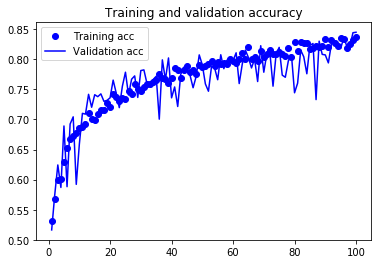

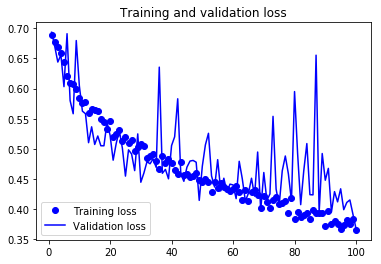

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we’re no longer overfitting: the training curves are closely tracking the validation curves. We now reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By using regularization techniques even further, and by tuning the network’s parameters we may be able to get an even better accuracy, likely up to 86% or 87%. But it would prove difficult to go any higher just by training our own convnet from scratch, because we have so little data to work with. As a next step to improve our accuracy on this problem, we’ll have to use a pretrained model.

### Classifying cats 🐈 vs dogs 🐕 pictures using a pretrained convnet

A pretrained network is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

We’ll use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014; it’s a simple and widely used convnet architecture for ImageNet. Although it’s an older model, far from the current state of the art and somewhat heavier than many other recent models.

In [16]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 12s 0us/step


* **weights** specifies the weight checkpoint from which to initialize the model.
* **include_top** refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because we intend to use our own densely connected classifier (with only two classes: cat and dog), we don’t need to include it.
* **input_shape** is the shape of the image tensors that we’ll feed to the network. This argument is purely optional: if we don’t pass it, the network will be able to process inputs of any size.

In [17]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

We will run the convolutional base over our dataset, record its output to a Numpy array on disk, and then use this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow you to use data augmentation.

#### Feature extraction

Feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.

In [18]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/src/cats_and_dogs'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512). You’ll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192):

In [19]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

#### Defining and training the densely connected classifier

In [20]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.5926 - acc: 0.6885 - val_loss: 0.4300 - val_acc: 0.8500
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4269 - acc: 0.8050 - val_loss: 0.3516 - val_acc: 0.8810
Epoch 3/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3540 - acc: 0.8625 - val_loss: 0.3149 - val_acc: 0.8930
Epoch 4/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3129 - acc: 0.8740 - val_loss: 0.3064 - val_acc: 0.8810
Epoch 5/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2939 - acc: 0.8795 - val_loss: 0.2792 - val_acc: 0.8980
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2539 - acc: 0.9035 - val_loss: 0.2724 - val_acc: 0.8890
Epoch 7/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2445 - acc: 0.9060 - val_loss: 0.2770 - val_acc: 0.8870
Epoch 8/30
200

#### Plotting the results

In [22]:
model.save('cats_and_dogs_small_3.h5')

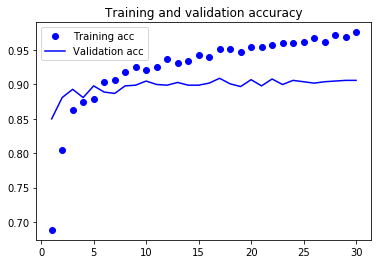

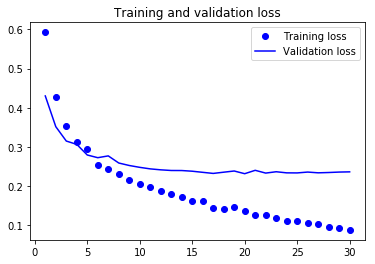

In [23]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We reach a validation accuracy of about 90%—much better than we achieved with the small model trained from scratch. But the plots also indicate that we’re overfitting almost from the start—despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.